<a href="https://colab.research.google.com/github/lo3e/CyKit/blob/master/NMRSpinChallenge/Hackathon_NMR_Challenge_July2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - NMR Challenge


### Problem Statement

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for<br>
the control and measurement of nuclear spins in crystals and molecules.<br>
- A common "recipe" for NMR is called the spin echo: the spins start aligned,<br>
begin to disperse, and are then refocused. This creates a sharp peak, or<br> "echo", in the net magnetization $M$ of the material at a later time. When the<br>
spins interact with each other, this refocused echo can become highly distorted.<br>
- Materials with strong electron-electron couplings have a variety of<br> applications, from superconductivity to ferromagnetism. They also tend to<br> enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of <br> these important systems.<br>
- Design and train a model that predicts the strength and shape of interactions<br>
between the nuclear spins from simulated time-dependent magnetization curves,<br>
$M(t)$.

Before getting to any code, we first review the structure of this machine<br> learning problem and introduce some of the details of the underlying physics we<br>
are trying to capture.




## Quick description of the ML problem

### Goal:
Predict three real numbers from an input vector of complex numbers.




# Further Theory For Those Interested

## Introduction to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following <br> animation created by Gavin W Morley (by way of <br>
https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!


![NMR Spin Echo Animation](https://upload.wikimedia.org/wikipedia/commons/9/9b/HahnEcho_GWM.gif)


The red arrows in this animation represents the values of nuclear spins in the <br>
material.

They all begin in the same direction (up), and then an applied magnetic field<br>
rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).<br>
A constant external magnetic field in the z-direction did not affect the spins <br>
when they were pointing "up", but now that they lie in the x-y plane they begin <br>
to precess.


Because each nuclear spin sits in a slightly different magnetic environment, <br>
each one has a slightly different response to the background z-direction <br> magnetic field, causing some to precess in a clockwise direction and others in <br>
a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic <br>
pulse is applied and rotates each spin 180$^\circ$ in the x-y plane. <br>
After this, the spins continue to move as they did before, but because of the <br>
180$^\circ$ pulse they are now effectively precessing  "backwards" compared to <br>
the original motion!<br>
So after an additional time $t$ passes, the variations in precession time is <br>
canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the <br>
material, and can be measured in experiments. <br>
This is an important technique because the average spin magnetization is hard <br>
to measure during an applied "pulse", but there is no external pulse during the <br>
"echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a <br> spin-echo in most materials:

![standard_spinecho.png](https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NMRSpinChallenge/standard_spinecho.png)

Sometimes, a more complicated curve can occur, such as:

![coupled_echo.png](https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NMRSpinChallenge/coupled_echo.png)

This more complicated structure has been caused by spin-spin interactions <br>
between the precessing nuclear spins. Normally, each spin precesses in a<br> uniform way irrespective of the rest of the nuclei in the material. In this <br>
coupled case, however, the nuclear magnetization that occurs near the "echo" <br>
influences the spins' motions, modifying the shape of the observed echo.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three <br> categories: metal, insulator, and semiconductor. <br>
These terms are based on a semi-classical description of the electrons in a <br>
crystal.<br>
The electrons are treated as a collection of classical particles, with energies <br>
that depend on their momentum in a way determined by the atomic structure of <br> the crystal.

However, there are other electronic phases of matter that are truly "quantum" <br>
and cannot be described accurately with a classical analogy. <Br>
In these scenarios, complicated structures in the electron states can give rise <br>
to large electronic spin density or strong electron-electron coupling. <br>
Because of these strong couplings between electrons, they are often hard to <br>
probe experimentally.

Luckily, electrons can interact with the nuclear spins of a material (by way of <br> the hyperfine-interaction).<br>
If the electron-nuclear coupling becomes strong enough, then a non-neglible <br>
two-step process can couple the nuclei with each other throughout the material. <br>
That two-step process is when a nuclear spin couples to an electron and changes <br>
its motion, and then that electron later "scatters" off another nuclear spin <br>
elsewhere in the material.

We represent this two-step scattering process by way of an effective spin-spin <br>
coupling between a nuclei at position $r_j$ and $r_i$. **There are two datasets,** <br>
**"gauss" and "RKKY", and thus you will have to generate TWO models and hand in** <br> **two models.**


The first is a simple gaussian function ("gauss"):

$T_1(i,j) = \alpha \exp{\left[ \left(\frac{-|r_j - r_i|}{\xi} \right)^{2} \right]}$

And the second is the traditional Ruderman–Kittel–Kasuya–Yosida function <br> ("RKKY"):

$T_2(i,j) = \alpha x^{-4} \left( x \cos{x} - \sin{x} \right)$

with $x = 2 \frac{|r_j - r_i|}{\xi}$


For both function, $\alpha$ is the coupling strength and $\xi$ is the coupling length.

Generally, $\alpha$ and $\xi$ will depend on the details of the nuclear-electron <br>
coupling and the quantum state of the electrons, but here we will sample them <br>
randomly to see if the spin-echo experiment can provide enough information to <br>
accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings <br>
with the environment the spin information can be "lost". <Br>
This occurs at a time scale $T_\textrm{decay} \simeq \Gamma^{-1/2}$, with $\Gamma$ given by:

$\Gamma = 10^{-d}$

Our goal is to develop two models, one for each function, that accurately <br> determine the above variables ($\alpha$, $\xi$, and $d$) from a single $M(t)$ curve. <br>
Note that RKKY is a harder problem.

# Coding Portion Begins Here

## Load and view the simulated data

Three datafiles will be used for the training of both models. Each file has <br>
6000 lines, representing 6000 simulated $M(t)$ curves for different choices of <br>
the three material parameters:

- \<model name\>_echos_model_r.txt  : Real part of the time-dependent <br> magnetization, $\textrm{Re}(M(t))$.
- \<model name\>_echos_model_i.txt  : Imaginary part of the time-dependent <br> magnetization, $\textrm{Im}(M(t))$.
- \<model name\>_mat_info_model.txt : The three material parameters <br> ($\alpha$,$\xi$,$d$) introduced above.

Where \<model name\> is either "gauss" or "RKKY".

We also load two other echo files, which give an additional 6000 $M(t)$ curves. <br>
These will be used to judge the quality of your final models:

- \<model name\>_echos_eval_r.txt
- \<model name\>_echos_eval_i.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

print("Downloading files off google drive...")

f_prefix = "gauss"

# data for model creation
gauss_train_y = f_prefix+"_mat_info_model.txt"
gauss_train_X_real = f_prefix+"_echos_model_r.txt" # real part of echos
gauss_train_X_imaginary = f_prefix+"_echos_model_i.txt" # imaginary part of echos

asdf = "https://drive.google.com/uc?export=download&id="

r = requests.get(asdf + "1J8CcJVQRpzSwue1vuHV9uB0bngdDrKCY",allow_redirects=True)
open(gauss_train_y, "wb").write(r.content)
r = requests.get(asdf + "1lBWcwF--1rrB8KCyCd0-5ZnPIjRrWkHg",allow_redirects=True)
open(gauss_train_X_real, "wb").write(r.content)
r = requests.get(asdf + "1O7KKL-SW3vHePoRNk8YfLzX82wf2Z5ul",allow_redirects=True)
open(gauss_train_X_imaginary, "wb").write(r.content)

# data for submission of final model
gauss_test_X_real = f_prefix+"_echos_eval_r.txt" # real part of echos
gauss_test_X_imaginary = f_prefix+"_echos_eval_i.txt" # imaginary part of echos

r = requests.get(asdf + "1prIrtO7XJs3PBe1MZiWUxK3VUkrChVvz",allow_redirects=True)
open(gauss_test_X_real, "wb").write(r.content)
r = requests.get(asdf + "1vbKcuxe6z8cRGQdTqj_Q2u5Oow0D9hbU",allow_redirects=True)
open(gauss_test_X_imaginary, "wb").write(r.content)

# now repeat, but for RKKY type function

f_prefix = "RKKY"

# data for model training
rrky_train_y = f_prefix+"_mat_info_model.txt"
rrky_train_X_real = f_prefix+"_echos_model_r.txt" # real part of echos
rrky_train_X_imaginary = f_prefix+"_echos_model_i.txt" # imaginary part of echos
r = requests.get(asdf + "1lS9AJ3sUFI4cfM5jQj618x4shoaJMXVo",allow_redirects=True)
open(rrky_train_y, "wb").write(r.content)
r = requests.get(asdf + "1J21bKy8FTjoaGzHVdLXlWAao2UiWO7ml",allow_redirects=True)
open(rrky_train_X_real, "wb").write(r.content)
r = requests.get(asdf + "1nf3Y_FcJJEWXJbjwREAkgcnVz2tDA__I",allow_redirects=True)
open(rrky_train_X_imaginary, "wb").write(r.content)

# data for submission of final model
rrky_test_X_real = f_prefix+"_echos_eval_r.txt" # real part of echos
rrky_test_X_imaginary = f_prefix+"_echos_eval_i.txt" # imaginary part of echos

r = requests.get(asdf + "1Q46o_RnYZFWEjMVVF5m1VBI9HCltspyY",allow_redirects=True)
open(rrky_test_X_real, "wb").write(r.content)
r = requests.get(asdf + "1-z2ADFrBlEhXN5Z_LHiRLA4Nds_9uvQq",allow_redirects=True)
open(rrky_test_X_imaginary, "wb").write(r.content)


print("Done with file downloads")

Done with file downloads


In [2]:

gauss_train_X_real = np.loadtxt(gauss_train_X_real, comments="#", delimiter=None, unpack=False)
gauss_train_X_imaginary = np.loadtxt(gauss_train_X_imaginary, comments="#", delimiter=None, unpack=False)
gauss_train_y = np.loadtxt(gauss_train_y, comments="#", delimiter=None, unpack=False)

gauss_test_X_real = np.loadtxt(gauss_test_X_real, comments="#", delimiter=None, unpack=False)
gauss_test_X_imaginary = np.loadtxt(gauss_test_X_imaginary, comments="#", delimiter=None, unpack=False)

rkky_train_X_real = np.loadtxt(rrky_train_X_real, comments="#", delimiter=None, unpack=False)
rkky_train_X_imaginary = np.loadtxt(rrky_train_X_imaginary, comments="#", delimiter=None, unpack=False)
rkky_train_y = np.loadtxt(rrky_train_y, comments="#", delimiter=None, unpack=False)

rkky_test_X_real = np.loadtxt(rrky_test_X_real, comments="#", delimiter=None, unpack=False)
rkky_test_X_imaginary = np.loadtxt(rrky_test_X_imaginary, comments="#", delimiter=None, unpack=False)

## IMPORTANT NOTE IF YOU WANT TO SAVE A LOT OF TIME WHILE TESTING THINGS

The full time series contain a lot of information that might not actually be <br>
useful. Here the key region of interest is around 200-400 so you could cut <br>
down the length of the time series to that window. It may slightly worsen <br>
final model performance but can save a ton of time.<br>
e.g. `gauss_train_X_imaginary = gauss_train_X_imaginary[:,200:400]`

/tmp/ipython-input-6-3699346563.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


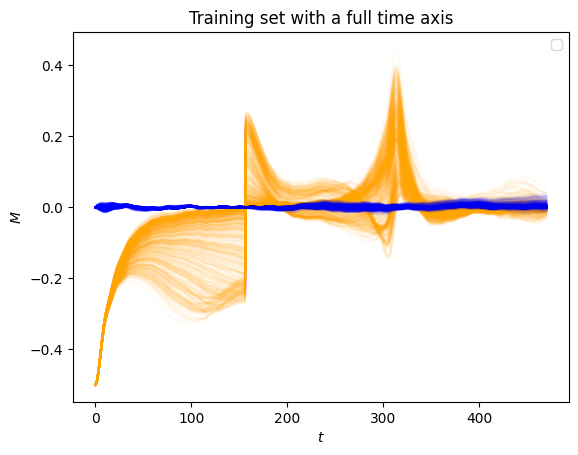

In [6]:
plt.plot((gauss_train_X_imaginary[1:500,:]).T,color='orange', alpha=0.05)
plt.plot((gauss_train_X_real[1:500,:]).T,color='blue', alpha=0.05)
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.legend()
plt.title("Training set with a full time axis")
plt.show()

In [7]:
# rescale data
from sklearn.preprocessing import StandardScaler
gauss_X_sc_real = StandardScaler()
gauss_train_X_real = gauss_X_sc_real.fit_transform(gauss_train_X_real)
gauss_test_X_real = gauss_X_sc_real.transform(gauss_test_X_real)
gauss_X_sc_imaginary = StandardScaler()
gauss_train_X_imaginary = gauss_X_sc_imaginary.fit_transform(gauss_train_X_imaginary)
gauss_test_X_imaginary = gauss_X_sc_imaginary.transform(gauss_test_X_imaginary)
gauss_y_sc = StandardScaler()
gauss_train_y = gauss_y_sc.fit_transform(gauss_train_y)

rkky_X_sc_real = StandardScaler()
rkky_train_X_real = rkky_X_sc_real.fit_transform(rkky_train_X_real)
rkky_test_X_real = rkky_X_sc_real.transform(rkky_test_X_real)
rkky_X_sc_imaginary = StandardScaler()
rkky_train_X_imaginary = rkky_X_sc_imaginary.fit_transform(rkky_train_X_imaginary)
rkky_test_X_imaginary = rkky_X_sc_imaginary.transform(rkky_test_X_imaginary)
rkky_y_sc = StandardScaler()
rkky_train_y = rkky_y_sc.fit_transform(rkky_train_y)

# partition data into a training and testing set using a random partition
from sklearn.model_selection import train_test_split
gauss_train_X_real, gauss_valid_X_real = train_test_split(gauss_train_X_real, test_size=0.1, random_state=42)
gauss_train_X_imaginary, gauss_valid_X_imaginary = train_test_split(gauss_train_X_imaginary, test_size=0.1, random_state=42)
gauss_train_y, gauss_valid_y = train_test_split(gauss_train_y, test_size=0.1, random_state=42)
rkky_train_X_real, rkky_valid_X_real = train_test_split(rkky_train_X_real, test_size=0.1, random_state=42)
rkky_train_X_imaginary, rkky_valid_X_imaginary = train_test_split(rkky_train_X_imaginary, test_size=0.1, random_state=42)
rkky_train_y, rkky_valid_y = train_test_split(rkky_train_y, test_size=0.1, random_state=42)

In [8]:
class TwoChannelTimeSeries(Dataset):
    def __init__(self, X, y=None):
        self.X = np.stack(X, axis=2)
        self.X = torch.from_numpy(self.X.copy()).float()
        if y is not None:
            self.y = torch.from_numpy(y.copy()).float()
        else:
            self.y = None
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

batch_size = 128

train_data = TwoChannelTimeSeries([gauss_train_X_real, gauss_train_X_imaginary], gauss_train_y)
valid_data = TwoChannelTimeSeries([gauss_valid_X_real, gauss_valid_X_imaginary], gauss_valid_y)
test_data = TwoChannelTimeSeries([gauss_test_X_real, gauss_test_X_imaginary], None)

gauss_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
gauss_valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
gauss_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_data = TwoChannelTimeSeries([rkky_train_X_real, rkky_train_X_imaginary], rkky_train_y)
valid_data = TwoChannelTimeSeries([rkky_valid_X_real, rkky_valid_X_imaginary], rkky_valid_y)
test_data = TwoChannelTimeSeries([rkky_test_X_real, rkky_test_X_imaginary], None)

rkky_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
rkky_valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
rkky_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y = y
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step()

    return history, model


def test_model(model, data_loader, criterion, metric=None, device='cpu'):
    model.to(device)  # Move the model to the specified device

    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Example solution: a simple neural net (NN)
- Our input nodes are the vector $[\textrm{Re}(M(t)), \textrm{Im}(M(t))]$, which is a few hundred elements.
- Our output nodes are the three material parameters.
- We will use a standard NN predict the material properties from $M(t)$.


In [11]:
# first we build the model

N = np.shape(next(iter(gauss_train_loader))[0])[1] # number of input values from M(t) curve

# define the net
simplenn = nn.Sequential()
# Let's try N -> 100 -> 40 -> 3, e.g. 2 hidden layers
simplenn.append(nn.Flatten())
simplenn.append(nn.Linear(N*2, 100))
simplenn.append(nn.ReLU())
simplenn.append(nn.Linear(100, 40))
simplenn.append(nn.ReLU())
simplenn.append(nn.Linear(40, 3))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=942, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=40, bias=True)
  (4): ReLU()
  (5): Linear(in_features=40, out_features=3, bias=True)
)

In [12]:
optimizer = torch.optim.Adam(simplenn.parameters(), lr=0.0001)
criterion = nn.MSELoss()
# now train it
history, simplenn = train_and_validate(gauss_train_loader, gauss_valid_loader, simplenn, optimizer, criterion, num_epochs=200, device=device)

Epoch [1/200], Train Loss: 0.8871, Train Metric: 0.0000, Val Loss: 0.7857, Val Metric: 0.0000
Epoch [2/200], Train Loss: 0.7008, Train Metric: 0.0000, Val Loss: 0.6206, Val Metric: 0.0000
Epoch [3/200], Train Loss: 0.5687, Train Metric: 0.0000, Val Loss: 0.5195, Val Metric: 0.0000
Epoch [4/200], Train Loss: 0.4840, Train Metric: 0.0000, Val Loss: 0.4498, Val Metric: 0.0000
Epoch [5/200], Train Loss: 0.4237, Train Metric: 0.0000, Val Loss: 0.3911, Val Metric: 0.0000
Epoch [6/200], Train Loss: 0.3697, Train Metric: 0.0000, Val Loss: 0.3439, Val Metric: 0.0000
Epoch [7/200], Train Loss: 0.3291, Train Metric: 0.0000, Val Loss: 0.3077, Val Metric: 0.0000
Epoch [8/200], Train Loss: 0.2938, Train Metric: 0.0000, Val Loss: 0.2745, Val Metric: 0.0000
Epoch [9/200], Train Loss: 0.2650, Train Metric: 0.0000, Val Loss: 0.2469, Val Metric: 0.0000
Epoch [10/200], Train Loss: 0.2425, Train Metric: 0.0000, Val Loss: 0.2217, Val Metric: 0.0000
Epoch [11/200], Train Loss: 0.2264, Train Metric: 0.0000, V

In [13]:
# check results on test set
results = test_model(simplenn, gauss_valid_loader, criterion, device=device)
print("test loss:", results)

Test Loss: 0.0381, Test Metric: 0.0000
test loss: (0.03814866840839386, 0.0)


In [14]:
simplenn.to('cpu')
simplenn.eval()
predictions = [simplenn(x[0]).detach().numpy() for x in gauss_valid_loader]
predictions = np.concatenate(predictions, axis=0)
predictions = gauss_y_sc.inverse_transform(predictions)
true = gauss_y_sc.inverse_transform(gauss_valid_loader.dataset.y.numpy())

## Model performance visualization

The quantities you are trying to predict and the associated predictions are <br>
shown below. They are `alpha`, `xi`, and `d`. Below true and predicted values <br>
are compared using a correlation plot.

Text(0.5, 1.0, 'Dissipation strength')

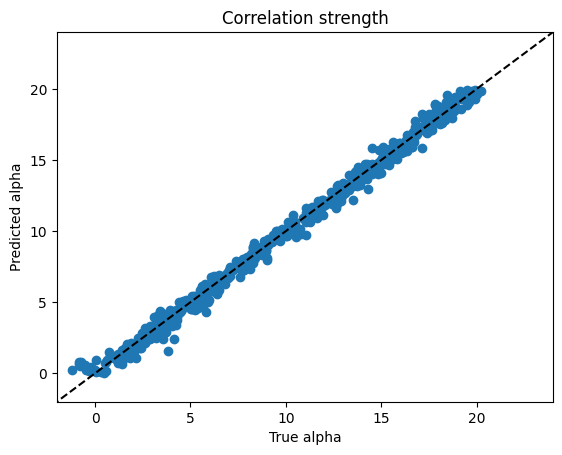

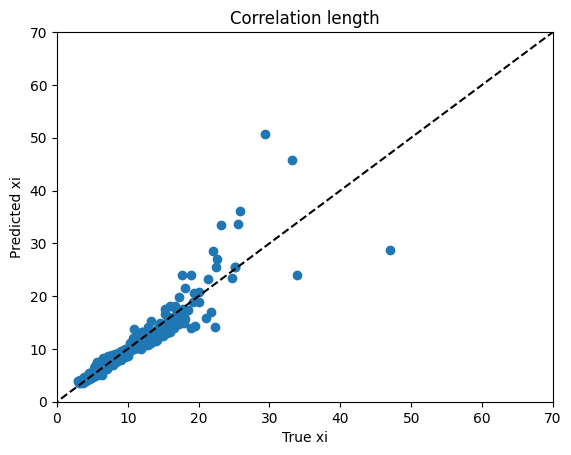

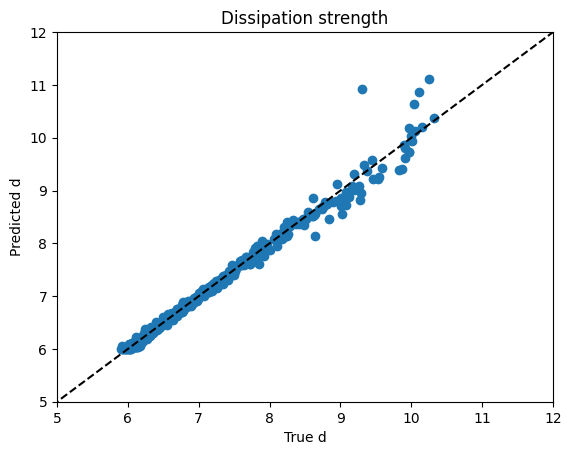

In [15]:
plt.scatter(predictions[:,0],true[:,0]);
plt.plot([-100,100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([-2, 24, -2, 24])
plt.title("Correlation strength")

plt.figure()
plt.scatter(predictions[:,1],true[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 70, 0, 70])
plt.title("Correlation length")

plt.figure()
plt.scatter(predictions[:,2],true[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([5, 12, 5, 12])
plt.title("Dissipation strength")

## Submission format

Fill out the pre- and post-hackathon surveys.

__We ask you to submit two models: one for guass and one for rkky__

We ask you to make your predictions on the test sets. You don't have the true <br>
labels for the test sets meaning you are limited only to what you know about <br>
train sets (and validation subsets) to build the best models possible.

Use your models to predict the three spin-interaction variables from the  <br>
echos, and submit your results for **each model** in a tab delimited .txt  <br>
file of dimensions 6000 x 3 matching the "\<model_type\>\_mat_info_model.txt" format.

That is, the columns should be:

| $\alpha$ | $\xi$ | $d$ |
      
and there should be 6000 rows.

Name this file "\<model_type\>_mat_info_eval.txt"

The quality of the model will be judged by the minimization of normalized <br> mean-square error:


$\textrm{Err} = \sum_{v=1}^{3} \sum_{i=i}^{6000} \left( \tilde{v}^i_\textrm{model} - \tilde{v}^i_\textrm{true} \right)^2 $

where $v^i$ is one of the three spin-interaction variables for echo number $i$, <br>
and the tilde represents normalization of each variable (using the <br> StandardScaler() object used above).


Your submission should include: <br>
- Your ipython notebook (`.ipynb`),<br>
- A PDF copy of your notebook together with a description of what you have done,<br>
- Your model's evaluation of the Gaussian data ("gauss_mat_info_eval.txt"), <br>
- Your model's evaluation of the RKKY data ("RKKY_mat_info_eval.txt").

**NOTE: If your final model prediction files aren't named** <br>
**"gauss_mat_info_eval.txt" and "RKKY_mat_info_eval.txt" your results might**<br>
**not be correctly evaluated by the automatic evaluation software.**


In [ ]:
# predictions = [simplenn(x).detach().numpy() for x in gauss_test_loader]
# predictions = np.concatenate(predictions, axis=0)
# predictions = gauss_y_sc.inverse_transform(predictions)
# np.savetxt("gauss_mat_info_eval.txt", predictions)

In [ ]:
# predictions = [simplenn(x).detach().numpy() for x in rkky_test_loader]
# predictions = np.concatenate(predictions, axis=0)
# predictions = rkky_y_sc.inverse_transform(predictions)
# np.savetxt("rkky_mat_info_eval.txt", predictions)